# uploading data

In [1]:
#from PIL import ImageOps
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import xmltodict
from numcodecs import Blosc
import numpy as np
import zarr as zarr
import tifffile as tf
from PIL import Image as im
import cv2 #for servers install package through: pip install opencv-contrib-python-headless
from skimage.io import imread
from skimage.exposure import cumulative_distribution #calculate the cumulative pixel value
import imagecodecs
from skimage import exposure
from skimage.exposure import match_histograms

In [2]:
polaris=tf.imread('/uftp/src/lowest_levels/polaris.tif')
huron_101010=tf.imread('/uftp/src/lowest_levels/huron_IHC_101010.tif')
huron_111219=tf.imread('/uftp/src/lowest_levels/huron_IHC_111219.tif')

In [3]:
polaris_a1=polaris[455:590, 100:235, :]
#plt.imshow(polaris_a1)

In [4]:
huron_a1_10=huron_101010[303:438, 64:199, :]
#plt.imshow(huron_a1_10)

In [5]:
huron_a1_3gammas=huron_111219[205:340, 488:623, :]
#plt.imshow(huron_a1_3gammas)

# gammas

In [35]:
#transfer function
def transfer_function(img, values, mode='linearization'):
  '''
  This function takes the image and performs transformation based on two modes: default 'linearization' outputs image with 1.0 gamma,
  any other input for 'mode' (e.g. 'correction') applies gamma(s) to an image. Single float/int number or list of numbers can be inputed
  as 'values' parameter (see dictionary below). 
  Gamma values: {'polaris_NTSC': 1.8, 'huron_sRGB_10_10_10': 2.2, 'huron_sRGB_11_12_19': [1.1, 1.2, 1.9]}
  '''

  img_norm=img/255.0 #converts array values from 0-255 range to 0-1
  if isinstance(values, (float, int)): #this part is needed to handle both single numbers and a list of gammas
    values = [values]
  if len(values)!=1:
    transposed=np.transpose(img_norm, (2,0,1)) #dimension with color channels becomes the first in order
    modified=np.empty_like(transposed)
    for i, gamma in enumerate(values):
      modified[i]=transposed[i]**(gamma if mode == 'linearization' else 1/gamma)
    modified=np.transpose(modified, (1,2,0))
  else:
    gamma = values[0]
    modified=img_norm**(gamma if mode == 'linearization' else 1/gamma)

  modified=(modified*255).astype(np.uint8)
  plt.imshow(modified)
  return modified

# histogram matching

In [43]:
#creating mask of a circle for grayscale images
def masking(img):
  gray_img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_circle=np.around(cv2.HoughCircles(gray_img, cv2.HOUGH_GRADIENT, 1.5, 50)).astype(np.uint8) #finds circle on an image
  coord=img_circle[0][0] #gets 1d x,y,r coordinates from 3d array from the previous step
  mask = np.zeros_like(gray_img, dtype=np.uint8) #creates empty array with a shape of the image
  cv2.circle(mask, (coord[0], coord[1]), coord[2], 255, -1) #applying a mask to the image

  return mask

In [46]:
img_mask_p=masking(polaris_a1)
#img_mask_h=masking(huron_a1_10) #doesn't work for huron images

In [23]:
masked_polaris = np.where(img_mask_p == 255, polaris_gray, 0)
masked_huron = np.where(img_mask_p == 255, huron_gray, 0)

In [ ]:
counts_pol, bins_pol = np.histogram(masked_polaris[img_mask_p == 255], bins=256, range=(0, 256))
counts_huron, bins_hur = np.histogram(masked_huron[img_mask_p == 255], bins=256, range=(0, 256))

In [24]:
#masked_image = cv2.bitwise_and(polaris_gray, polaris_gray, mask=img_mask_p)
#plt.imshow(masked_image)

In [47]:
def histogram_matching(source, reference, mask):
    matched = np.copy(source)
    for channel in range(source.shape[2]):
        source_channel = source[:, :, channel]
        reference_channel = reference[:, :, channel]
        mask_channel = mask > 0
        matched_channel = exposure.match_histograms(source_channel[mask_channel], reference_channel[mask_channel])
        matched_channel_full = np.zeros_like(source_channel)
        matched_channel_full[mask_channel] = matched_channel
        matched[:, :, channel] = matched_channel_full
    return matched

In [48]:
matched_image = histogram_matching(huron_a1_10, polaris_a1, img_mask_p)

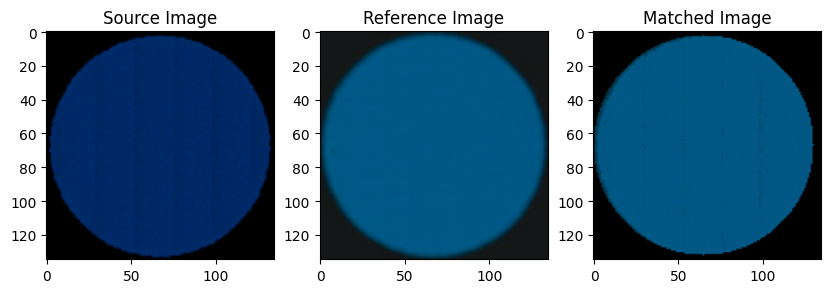

In [49]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title('Source Image')
plt.imshow(huron_a1_10)
plt.subplot(1, 3, 2)
plt.title('Reference Image')
plt.imshow(polaris_a1)
plt.subplot(1, 3, 3)
plt.title('Matched Image')
plt.imshow(matched_image)
plt.show()